# DFT and inverse DFT with PyDynamic - best practice guide

The discrete Fourier transform (DFT) and its inverse (iDFT) are common tools in dynamic metrology. For the corresponding propagation of uncertainties, *PyDynamic* implements the main tools required:

**Uncertainty propagation for the discrete Fourier transform**
```python 
    GUM_DFT(x,Ux,N=None,window=None,CxCos=None,CxSin=None,returnC=False,mask=None)
```

**Uncertainty propagation for the inverse discrete Fourier transform**
```python
    GUM_iDFT(F,UF,Nx=None,Cc=None,Cs=None,returnC=False)
```

**Uncertainty propagation for convolution in the frequency domain**
```python
    DFT_multiply(Y, UY, F, UF=None)
```

**Uncertainty propagation for deconvolution in the frequency domain**
```python
    DFT_deconv(H, Y, UH, UY)
```

In the following we discuss common use cases for these methods and present guidance on how to utilize the optional arguments of the above methods.

## Prerequisites

Get started with the notebook by importing some packages:

In [23]:
# base imports
import matplotlib
import matplotlib.pyplot as plt

# convenience imports
from scipy.signal import butter, cheby2, freqs
from numpy import (
    pi, 
    random, 
    fft, 
    arange, 
    sqrt, 
    mean,
    std,
    abs,
    diag, 
    full_like,
    zeros_like,
    empty,
)
from numpy.testing import assert_allclose
from matplotlib.pyplot import plot
from PyDynamic.uncertainty.propagate_DFT import (
    GUM_DFT,
    GUM_iDFT,
    DFT_multiply,
    DFT_deconv,
)
from PyDynamic.model_estimation.fit_filter import _assemble_complex_from_real_imag as ri2c
from PyDynamic.model_estimation.fit_filter import _assemble_real_imag_from_complex as c2ri
from PyDynamic.misc.testsignals import multi_sine

# set up matplotlib
%matplotlib inline
# %matplotlib notebook
matplotlib.rc("font", size=12)
matplotlib.rc("figure", figsize=(9, 5))

# small helper functions for visualization
def get_amplitudes(V):
    return abs(ri2c(V))

def plot_unc(ax, time, values, values_unc, label="", **args):
    ax.plot(time, values, label=label, **args)
    ax.fill_between(time, values - values_unc, values + values_unc, alpha=0.3, **args)
    return ax

## 1) Discrete Fourier Transform (DFT)

The first and most basic scenario is the application of the discrete Fourier transform to analyse a time domain signal in the frequency domain. 

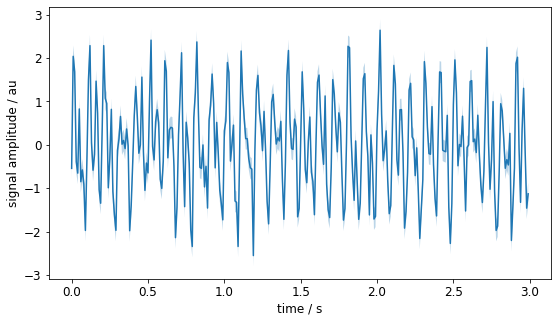

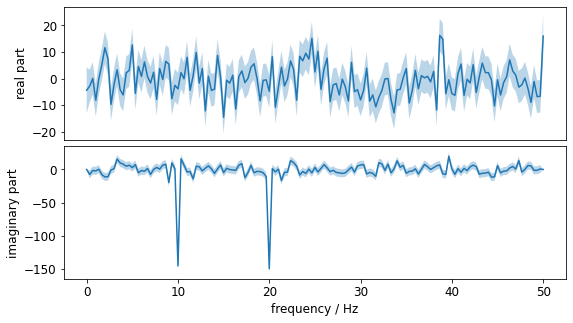

In [24]:
Fs = 100  # sampling frequency in Hz
Ts = 1 / Fs  # sampling interval in s
N = 300  # number of samples
time = arange(0, N * Ts, Ts)  # time instants
noise_std = 0.5  # signal noise standard deviation

# time domain signal
x = multi_sine(time, amps=[1.0, 1.0], freqs=[10, 20], noise=noise_std)
ux = full_like(x, noise_std ** 2)

X, UX = GUM_DFT(x, ux)  # application of DFT with propagation of uncertainties
f = fft.rfftfreq(N, Ts)  # frequency values

# plotting
_, ax = plt.subplots()
plot_unc(ax, time, x, ux)
ax.set_xlabel("time / s")
ax.set_ylabel("signal amplitude / au")

_, ax = plt.subplots(2, 1)
plot_unc(ax[0], f, X[: len(f)], sqrt(diag(UX)[: len(f)]))
ax[0].set_ylabel("real part")
ax[0].set_xticks([])

plot_unc(ax[1], f, X[len(f) :], sqrt(diag(UX)[len(f) :]))
ax[1].set_ylabel("imaginary part")
ax[1].set_xlabel("frequency / Hz")

_.subplots_adjust(hspace=0.05)


## 2) Inverse Discrete Fourier Transform (iDFT)

Let's transform our signal spectrum back into the time-domain. This yields an _exact_ identity of `x` and `x_back_and_forth` and their assigned uncertainties. (Of course, this should be of no surprise, as we didn't modify anything and the DFT and iDFT form an identity pair.)

Note: In the plot the original signal is plotted with an offset of 0.1 to better visualize despite the identity. 

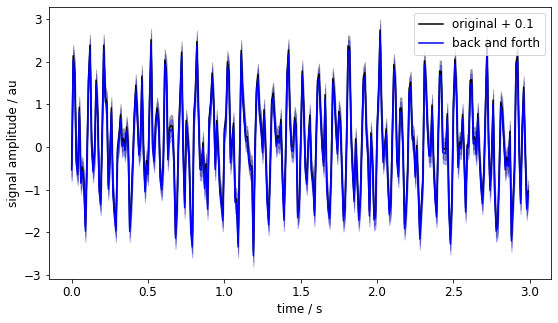

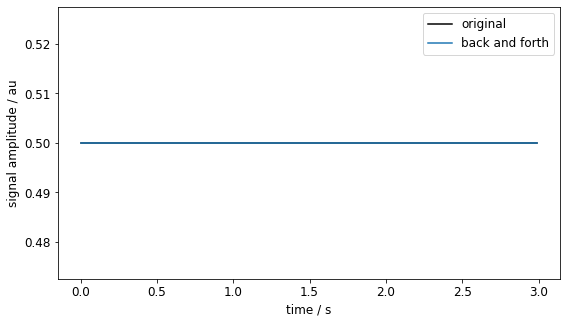

In [25]:
# transform the frequency spectrum back to the time domain
x_back_and_forth, ux_back_and_forth = GUM_iDFT(X, UX)

# check numerical closeness
assert_allclose(x, x_back_and_forth)
assert_allclose(ux, diag(ux_back_and_forth))

# visualize the time-signal
_, ax = plt.subplots()
plot_unc(ax, time, x + 0.1, ux, label="original + 0.1", color="k")
plot_unc(
    ax,
    time,
    x_back_and_forth,
    diag(ux_back_and_forth),
    label="back and forth",
    color="b",
)
ax.set_xlabel("time / s")
ax.set_ylabel("signal amplitude / au")
ax.legend()

# visualize the uncertainties associated with x and x_back_and_forth
_, ax = plt.subplots()
ax.plot(time, sqrt(ux), "-k", label="original")
ax.plot(time, sqrt(diag(ux_back_and_forth)), label="back and forth")
ax.set_xlabel("time / s")
ax.set_ylabel("signal amplitude / au")
ax.legend()


## 3) Multiply Spectra in the Frequency Domain

Multiplication in the frequency domain corresponds to a convolution of two signals in the time domain. 

Let's consider again the signal `x` from above. We have already transformed it to the frequency domain in *section 1)*, which resulted in the spectrum `X` of the signal. We now want to apply a lowpass filter `H` that attenuates the highest of the both dominant frequencies. So we should design a filter such that it has a cutoff frequency around 15Hz. 

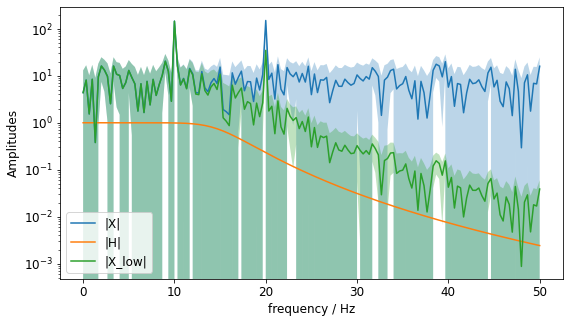

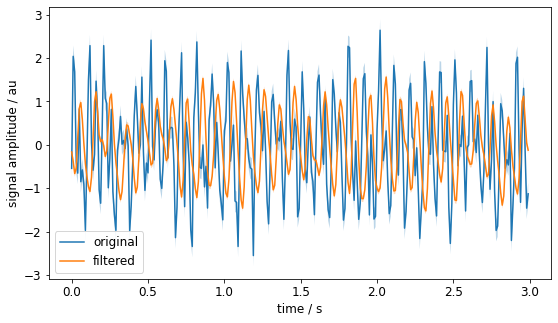

In [26]:
cutoff_frequency = 15
b, a = butter(5, 2 * pi * cutoff_frequency, "low", analog=True)
_, H = freqs(
    b, a, worN=2 * pi * f
)  # get our filter at the same positions as X is already known

# bring H into the required shape for DFT_multiply
H = c2ri(H)

# apply the lowpass H to X
X_low, UX_low = DFT_multiply(X, H, UX)

# transform to time domain
x_low, ux_low = GUM_iDFT(X_low, UX_low)

# visualize the multiplication by showing its effect on spectrum amplitudes
_, ax = plt.subplots()
plot_unc(ax, f, get_amplitudes(X), get_amplitudes(sqrt(diag(UX))), label="|X|")
plot_unc(ax, f, get_amplitudes(H), zeros_like(f), label="|H|")
plot_unc(
    ax, f, get_amplitudes(X_low), get_amplitudes(sqrt(diag(UX_low))), label="|X_low|"
)
ax.set_xlabel("frequency / Hz")
ax.set_ylabel("Amplitudes")
ax.set_yscale("log")
ax.legend()

# visualize the time-domain by comparing the original `x` and lowpass-filtered `x_low` signals
_, ax = plt.subplots()
plot_unc(ax, time, x, ux, label="original")
plot_unc(ax, time, x_low, diag(ux_low), label="filtered")
ax.set_xlabel("time / s")
ax.set_ylabel("signal amplitude / au")
ax.legend()


## 4) Deconvolve Signals by Division of Spectra

It could be of interest to remove the effect of a system's transfer function on a signal. This can be achieved in the frequency domain by a simple division of the signal spectrum and the system's transfer function. This corresponds to a deconvolution in the time-domain (a.k.a. convolution with the inverse filter). 

In our example, let's undo the lowpass operation from *section 3)*. But to make it a bit more interesting, let's assume, we don't know the exact cutoff-frequency but only with an uncertainty of 1Hz. 

There are two steps:

1. Check the influence of the cutoff frequency on the actual frequency spectrum. This is done by a Monte Carlo method. 
2. Division of both spectra: The reconstructed signal can then be transformed back to the time-domain, where the uncertainties of original and reconstruction are compared. 

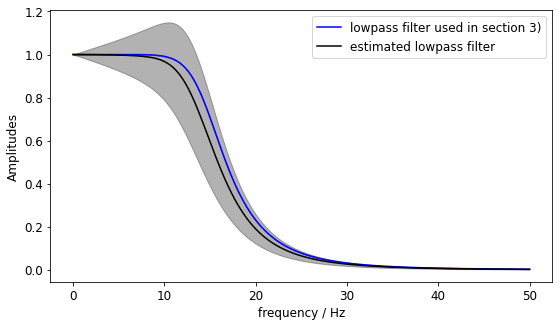

In [27]:
cutoff_frequency_estimate = 14.5  # Hz
cutoff_frequency_unc = 1.0  # Hz

# step 1: Monte Carlo
mc_runs = 100
h_array = empty((mc_runs, len(f)), dtype="complex")
for i in range(mc_runs):
    cf = random.normal(cutoff_frequency_estimate, cutoff_frequency_unc)
    b, a = butter(5, 2 * pi * cf, "low", analog=True)
    _, H_tmp = freqs(b, a, worN=2 * pi * f)
    h_array[i, :] = H_tmp

H_estimated_lowpass = mean(c2ri(h_array), axis=0)
UH_estimated_lowpass = std(c2ri(h_array), axis=0)

# visualize the uncertain lowpass filter
_, ax = plt.subplots()
plot_unc(
    ax,
    f,
    get_amplitudes(H),
    zeros_like(f),
    label="lowpass filter used in section 3)",
    color="b",
)
plot_unc(
    ax,
    f,
    get_amplitudes(H_estimated_lowpass),
    get_amplitudes(UH_estimated_lowpass),
    label="estimated lowpass filter",
    color="k",
)
ax.set_xlabel("frequency / Hz")
ax.set_ylabel("Amplitudes")
ax.set_yscale("linear")
ax.legend()


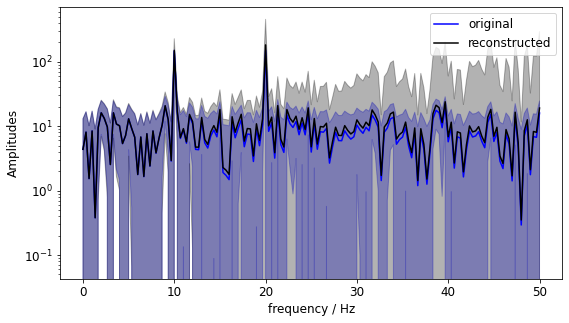

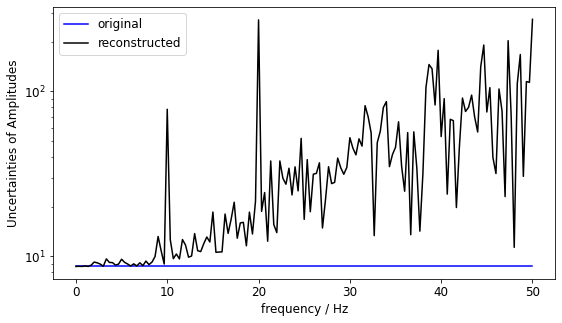

In [28]:
# step 2
X_recon, UX_recon = DFT_deconv(
    H_estimated_lowpass, X_low, diag(UH_estimated_lowpass), UX_low
)

# visualize the uncertain reconstruction of the spectrum amplitudes
_, ax = plt.subplots()
plot_unc(
    ax,
    f,
    get_amplitudes(X),
    get_amplitudes(sqrt(diag(UX))),
    label="original",
    color="b",
)
plot_unc(
    ax,
    f,
    get_amplitudes(X_recon),
    get_amplitudes(sqrt(diag(UX_recon))),
    label="reconstructed",
    color="k",
)
ax.set_xlabel("frequency / Hz")
ax.set_ylabel("Amplitudes")
ax.set_yscale("log")
ax.legend()

# visualize the uncertain reconstruction of the spectrum amplitude uncertainties
_, ax = plt.subplots()
plot(f, get_amplitudes(sqrt(diag(UX))), "b", label="original")
plot(f, get_amplitudes(sqrt(diag(UX_recon))), "k", label="reconstructed")
ax.set_xlabel("frequency / Hz")
ax.set_ylabel("Uncertainties of Amplitudes")
ax.set_yscale("log")
ax.legend()


Note: 
We just divided by the lowpass' transfer function. To readers with some background in control theory it should be obvious that this amplifies high frequencies and might lead to instabilities if used inside a control loop. However, because we are taking the signal's and filter's uncertainty into account, the reconstructed spectrum shows us just that - _that the higher spectrum values are much more uncertain._

## 5) Exemplary Regularization

To counter the effect seen in the last section, it is common to introduce some kind of regularization. 
E.g. in the reconstruction above, we may have the additional information about our input signal that all the interesting parts are below 25Hz and only noise is expected above. 
It is therefore safe to overlay the reconstructed signal with an additional (deterministic) low-pass with its cutoff-frequency at 35Hz. 

For further information on this topic, please refer to e.g. [Eichstädt & Wilkens (2017)](https://doi.org/10.1121/1.4983827)

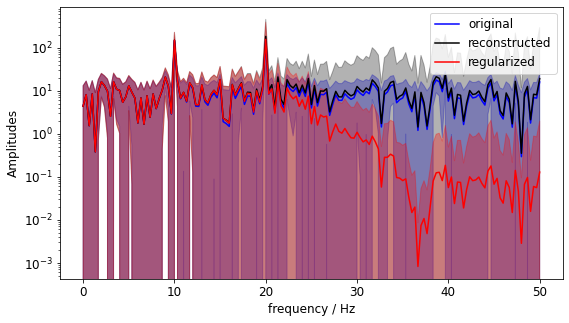

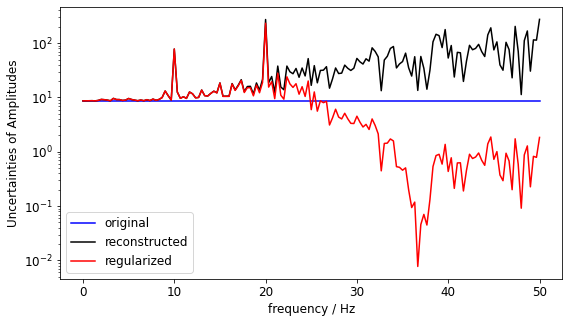

In [29]:
# define a filter to remove high frequencies of reconstructed signal
b_reg, a_reg = cheby2(5, 40, 2 * pi * 35, "low", analog=True)
_, H_reg = freqs(b_reg, a_reg, worN=2 * pi * f)
H_reg = c2ri(H_reg)

# apply regularization to reconstructed signal
X_reg, UX_reg = DFT_multiply(X_recon, H_reg, UX_recon)

# visualize and compare the regularization of the spectrum amplitudes
_, ax = plt.subplots()
plot_unc(
    ax,
    f,
    get_amplitudes(X),
    get_amplitudes(sqrt(diag(UX))),
    label="original",
    color="b",
)
plot_unc(
    ax,
    f,
    get_amplitudes(X_recon),
    get_amplitudes(sqrt(diag(UX_recon))),
    label="reconstructed",
    color="k",
)
plot_unc(
    ax,
    f,
    get_amplitudes(X_reg),
    get_amplitudes(sqrt(diag(UX_reg))),
    label="regularized",
    color="r",
)
ax.set_xlabel("frequency / Hz")
ax.set_ylabel("Amplitudes")
ax.set_yscale("log")
ax.legend()


# visualize and compare the regularization of the spectrum amplitudes
_, ax = plt.subplots()
plot(f, get_amplitudes(sqrt(diag(UX))), "b", label="original")
plot(f, get_amplitudes(sqrt(diag(UX_recon))), "k", label="reconstructed")
plot(f, get_amplitudes(sqrt(diag(UX_reg))), "r", label="regularized")
ax.set_xlabel("frequency / Hz")
ax.set_ylabel("Uncertainties of Amplitudes")
ax.set_yscale("log")
ax.legend()
